In [242]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
from matplotlib import pyplot as plt
from pprint import pprint
from tqdm import tqdm
%matplotlib auto
sns.set(style="darkgrid")
MODELS_LOG = "../model_logs"

Using matplotlib backend: TkAgg


In [221]:
models = [x for x in os.listdir(MODELS_LOG)]
models_setting = [re.compile("\.(?=[a-zA-Z])").split(model) for model in models]

In [222]:
models

['partial-gen.DocInfo1.lr0.01.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.0001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1.BNafterStochastic',
 'partial-gen.DocInfo1.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta0',
 'partial-gen.DocInfo1.lr0.00021.BNonNormal0.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr1e-05.BNonNormal0.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.01.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo1.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.

In [230]:
def plot_models(models, save=True):
    %matplotlib inline
    measure2idx = {
    "nll": 0,
    "nkld": 1,
    "npmi": 2,
    "loss": 3
    }
    idx2meansure = {v: k for k, v in measure2idx.items()}
    num_measure = len(measure2idx)


    model_ave_train = [None for _ in models]
    model_ave_dev = [None for _ in models]

    model_std_train = [None for _ in models]
    model_std_dev = [None for _ in models]
    
    result = []

    for model_idx, model_name in enumerate(models):
        model_dir = f"{MODELS_LOG}/{model_name}"
        experiments = sorted(os.listdir(model_dir), key=lambda x: int(x.split("_")[0][-1]), reverse=True)
        metrics = [None for i in range(len(experiments))]
        metrics_json = [None for i in range(len(experiments))]

        all_training_nll, all_training_nkld, all_training_npmi, all_training_loss = [], [], [], []
        all_validation_nll, all_validation_nkld, all_validation_npmi, all_validation_loss = [], [], [], []

        for i, experiment in enumerate(experiments):
            experiment_dir = f"{model_dir}/{experiment}"
            metrics[i] = [y for x in os.walk(experiment_dir) for y in glob(os.path.join(x[0], 'metrics_epoch_*.json'))]
            metrics[i] = sorted(metrics[i], key=lambda x: int(x.split("_")[-1].split(".")[0]))
            metrics_json[i] = [json.load(open(metric, "r")) for metric in metrics[i]]
#             best_epoch = [metrics_json[i][-1]["best_epoch"]][0]
#             best_topic_file_name = f"{experiment_dir}/topics/topics_{best_epoch}.txt"
#             print(open(best_topic_file_name, "r"))
            
            training_nll = [metric["training_nll"] for metric in metrics_json[i]]
            if len(training_nll) == 0:
                continue
            training_nkld = [metric["training_nkld"] for metric in metrics_json[i]]
            training_npmi = [metric["training_npmi"] for metric in metrics_json[i]]
            training_loss = [metric["training_loss"] for metric in metrics_json[i]]

            validation_nll = [metric["validation_nll"] for metric in metrics_json[i]]
            validation_nkld = [metric["validation_nkld"] for metric in metrics_json[i]]
            validation_npmi = [metric["validation_npmi"] for metric in metrics_json[i]]
            validation_loss = [metric["validation_loss"] for metric in metrics_json[i]]

            all_training_nll.append(training_nll)
            all_training_nkld.append(training_nkld)
            all_training_npmi.append(training_npmi)
            all_training_loss.append(training_loss)

            all_validation_nll.append(validation_nll)
            all_validation_nkld.append(validation_nkld)
            all_validation_npmi.append(validation_npmi)
            all_validation_loss.append(validation_loss)
        
        result.append(all_training_npmi)
        
        max_epoch = max([len(elm) for elm in all_training_nll])
        num_trial = len(all_training_nll)

        train_result = [
            np.array([all_training_nll[i], all_training_nkld[i], 
                      all_training_npmi[i], all_training_loss[i]])
            for i in range(num_trial)
        ]

        dev_result = [
            np.array([all_validation_nll[i], all_validation_nkld[i], 
                      all_validation_npmi[i], all_validation_loss[i]])
            for i in range(num_trial)
        ]

        # no. of dev result and no. of train results are the same
        assert all(len(train_result[i]) == len(train_result[i]) for i in range(num_trial))

        # create masked array for summation
        train_arr = np.ma.empty((num_measure, max_epoch, num_trial))
        dev_arr = np.ma.empty((num_measure, max_epoch, num_trial))
        train_arr.mask = True
        dev_arr.mask = True
        # put result in the mask array
        for i in range(num_trial):
            train_x = train_result[i]
            dev_x = dev_result[i]

            train_arr[:train_x.shape[0], :train_x.shape[1], i] = train_x
            dev_arr[:dev_x.shape[0], :dev_x.shape[1], i] = dev_x

        ave_train = train_arr.mean(axis=2)
        ave_dev = dev_arr.mean(axis=2)
        std_train = train_arr.std(axis=2)
        std_dev = dev_arr.std(axis=2)

        model_ave_train[model_idx] = ave_train
        model_ave_dev[model_idx] = ave_dev
        model_std_train[model_idx] = std_train
        model_std_dev[model_idx] = std_dev

        ave_train_result = {idx2meansure[i]: ave_train[i] for i in range(num_measure)}
        ave_dev_result = {idx2meansure[i]: ave_dev[i] for i in range(num_measure)}
        std_train_result = {idx2meansure[i]: std_train[i] for i in range(num_measure)}
        std_dev_result = {idx2meansure[i]: std_dev[i] for i in range(num_measure)}

        fig, axes = plt.subplots(nrows=1, ncols=4,  figsize=(15, 3 * 1))
        epochs = np.arange(max_epoch)

        for i, metric_name in enumerate(measure2idx.keys()):
            train_ave = ave_train_result[metric_name]
            dev_ave = ave_dev_result[metric_name]
            train_std = std_train_result[metric_name]
            dev_std = std_dev_result[metric_name]

            axes[i].title.set_text(metric_name.upper())
            axes[i].plot(epochs, dev_ave, label=f"dev_{metric_name}")
            axes[i].fill_between(epochs, dev_ave-dev_std, dev_ave+dev_std, alpha=0.4)
            if metric_name != "npmi":
                axes[i].plot(epochs, train_ave, label=f"train_{metric_name}")
                axes[i].fill_between(epochs, train_ave-train_std, train_ave+train_std, alpha=0.4)
            axes[i].legend()

        fig.suptitle(model_name)
        plt.subplots_adjust(top=0.85)
        plt.ylim(0, 500)
        if save:
            plt.savefig(f"{model_name}_AVE.png")
        plt.show()
    return result

In [181]:
%matplotlib inline

In [148]:
df = pd.read_excel("../experiments.xlsx")
df

,Model,DocInfo,lr,BNonNormal,BNonDecoder,StochasticBeta
0,partial-gen,1,0.01000,1,0,0
1,partial-gen,0,0.00100,1,1,1
2,partial-gen,0,0.00010,1,0,0
3,partial-gen,1,0.00100,1,1,0
4,partial-gen,1,0.00021,0,0,0
5,partial-gen,0,0.00001,0,0,0
6,partial-gen,0,0.00100,1,0,0
7,partial-gen,0,0.01000,1,0,0
8,partial-gen,1,0.00100,1,0,0
9,partial-gen,0,0.00100,1,1,0


In [286]:
# list(df.groupby([elm for elm in df.columns if elm != "DocInfo"])) # compare DocInfo

In [140]:
# list(df.groupby([elm for elm in df.columns if elm != "lr"])) # compare lr

In [287]:
list(df.groupby([elm for elm in df.columns if elm != "BNonDecoder"])) # compare BNonDecoder

[(('partial-gen', 0, 1e-05, 0, 0),
           Model  DocInfo       lr  BNonNormal  BNonDecoder  StochasticBeta
  5  partial-gen        0  0.00001           0            0               0),
 (('partial-gen', 0, 1e-05, 1, 0),
            Model  DocInfo       lr  BNonNormal  BNonDecoder  StochasticBeta
  10  partial-gen        0  0.00001           1            0               0),
 (('partial-gen', 0, 0.0001, 1, 0),
           Model  DocInfo      lr  BNonNormal  BNonDecoder  StochasticBeta
  2  partial-gen        0  0.0001           1            0               0),
 (('partial-gen', 0, 0.001, 1, 0),
           Model  DocInfo     lr  BNonNormal  BNonDecoder  StochasticBeta
  6  partial-gen        0  0.001           1            0               0
  9  partial-gen        0  0.001           1            1               0),
 (('partial-gen', 0, 0.001, 1, 1),
           Model  DocInfo     lr  BNonNormal  BNonDecoder  StochasticBeta
  1  partial-gen        0  0.001           1            1       

In [173]:
# list(df.groupby([elm for elm in df.columns if elm != "BNonNormal"])) # compaure BNonNormal

In [288]:
# list(df.groupby(["BNonNormal", "BNonDecoder"]))

# Compare model with Non-Linearity(No BNonDecoder, BN not learnable)
It seems that with non-linearity applied on beta(no batch-norm), the performance are (mostly) better, although some are more stable than others.

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.SigmoidBeta1']


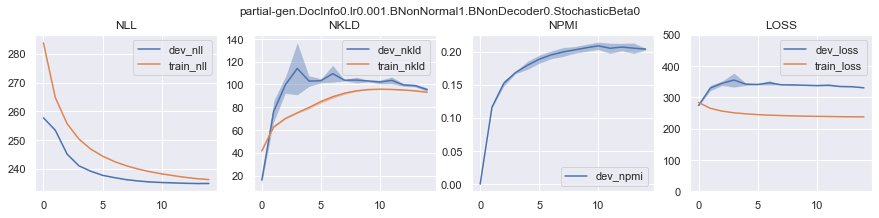

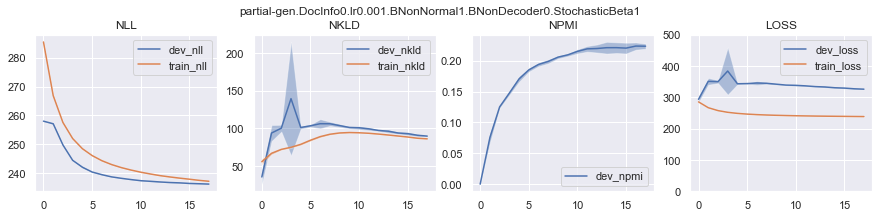

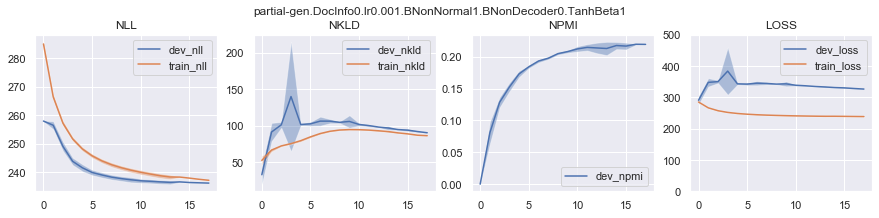

/home/lzy/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/ma/core.py:4212: RuntimeWarning: invalid value encountered in multiply
  getdata(other)))


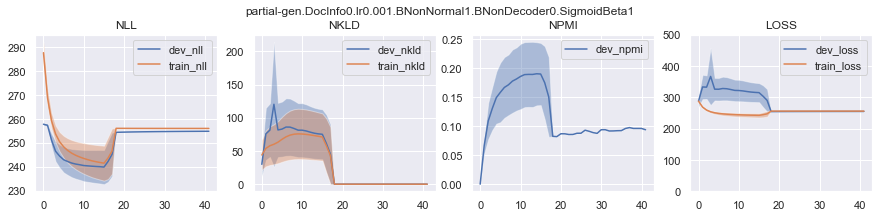

In [322]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1.BNonDecoder0' in model ]
pprint(tmp)
compare_non_linearity = [tmp[1], tmp[2], tmp[0], tmp[3]]
_ = plot_models(compare_non_linearity)

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta0']


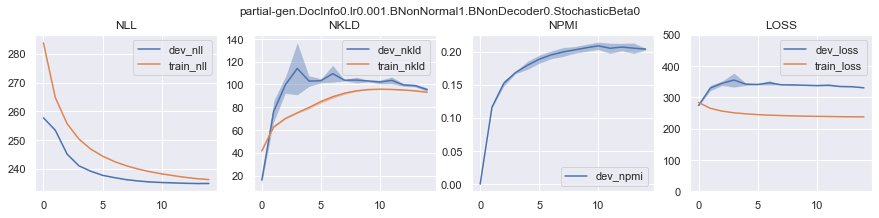

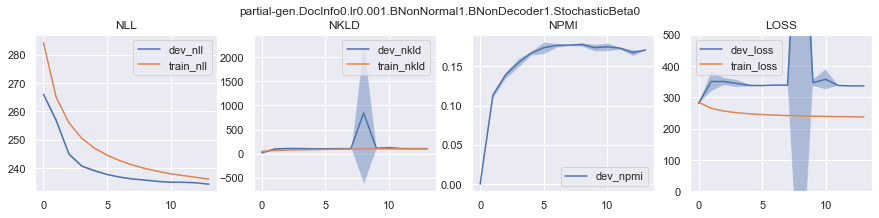

In [306]:
compare_prodlda = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1' in model and "StochasticBeta0" in model ]
pprint(compare_prodlda)
_ = plot_models(compare_prodlda)

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1.BNafterStochastic',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta1']


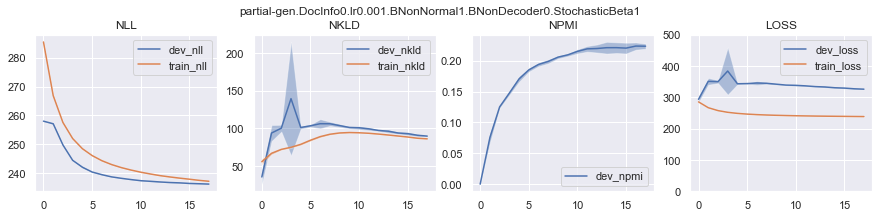

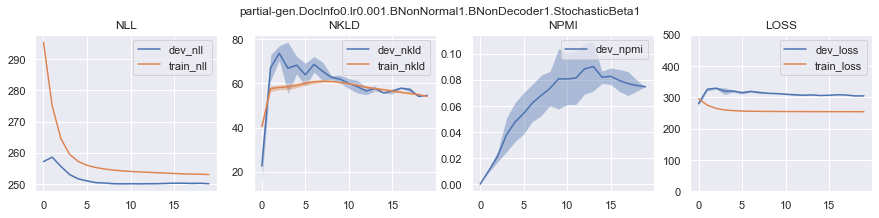

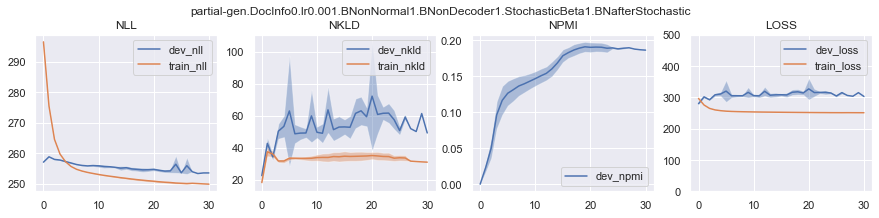

In [312]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1' in model and "StochasticBeta1" in model ]
pprint(tmp)
compare_nvlda = [tmp[-1]] +  tmp[:2]
_ = plot_models(compare_nvlda)

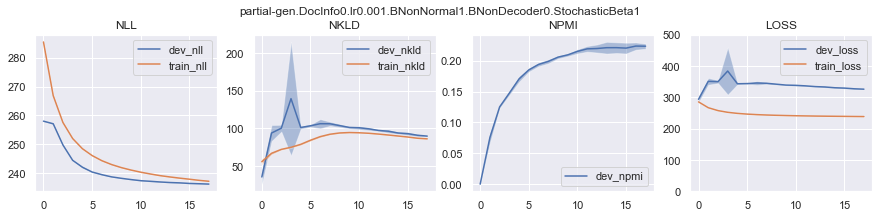

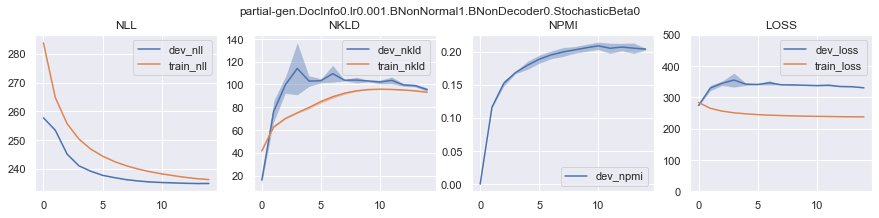

In [321]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1.BNonDecoder0' in model]
compare_prodlda_nvlda = tmp[1:3][::-1]
_ = plot_models(compare_prodlda_nvlda)

# Compare model with Non-Linearity(BNonDecoder, only BN bias learnable)
It seem when BN combined with non-linearity is applied on beta, the performance are not as good as without. The order of BN and non-linearity matters (mostly) for stability and quality

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1.BNafterStochastic',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.SigmoidBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1.BNafterTanh',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.SigmoidBeta1.BNafterSigmoid']


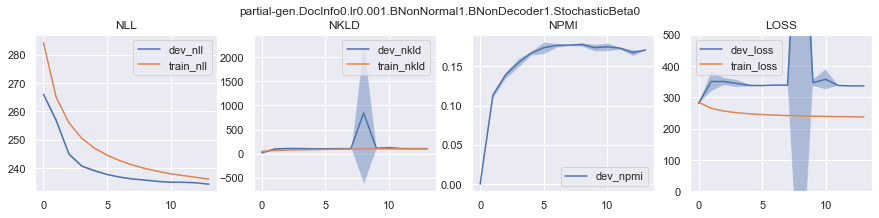

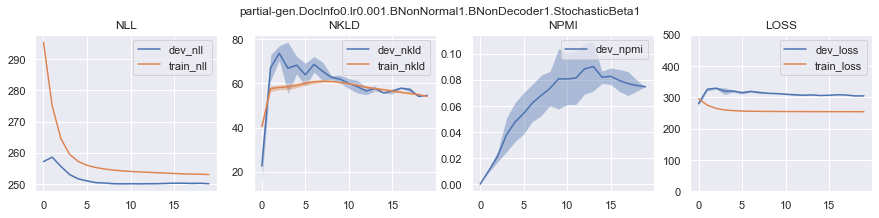

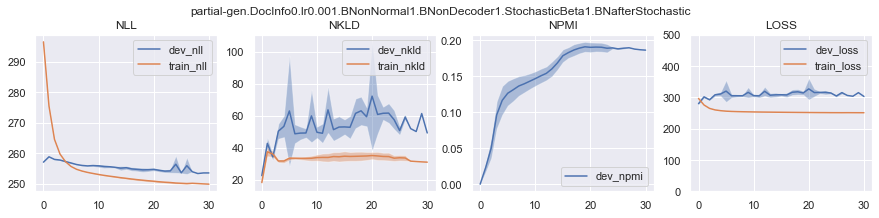

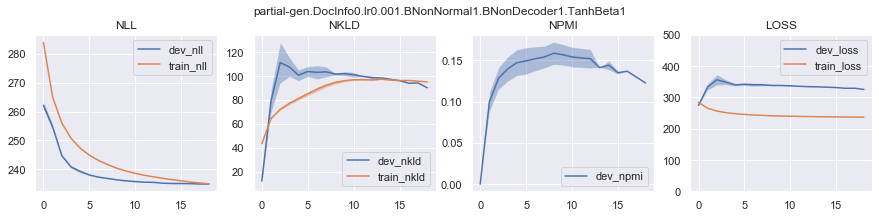

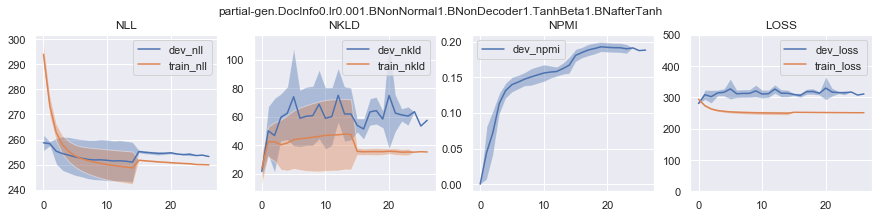

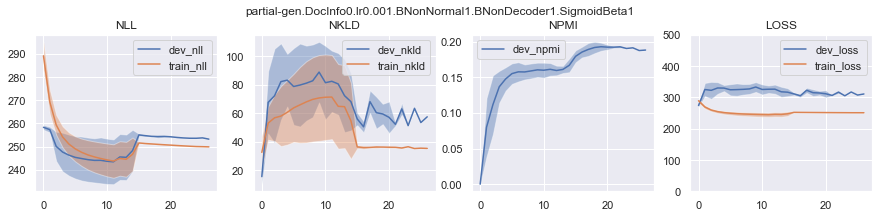

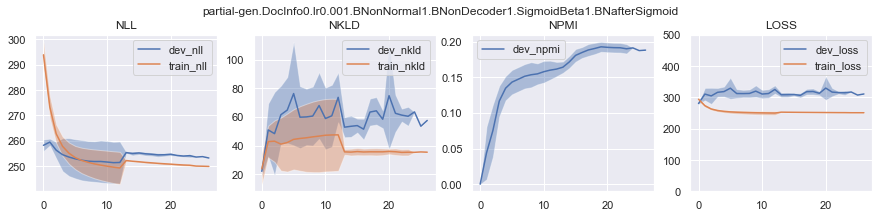

In [251]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1.BNonDecoder1' in model ]
pprint(tmp)
compare_non_linearity_BNonDecoder = [tmp[3], tmp[0], tmp[1], tmp[2], tmp[5], tmp[4], tmp[6]]
_ = plot_models(compare_non_linearity_BNonDecoder)

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1.BNafterTanh']


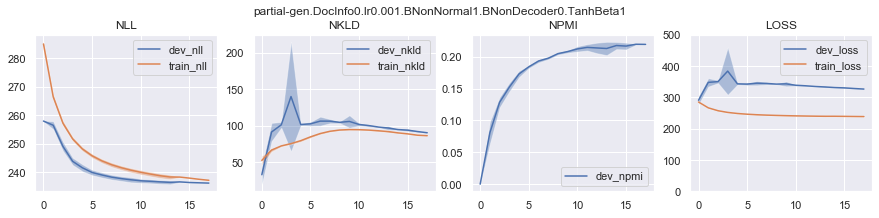

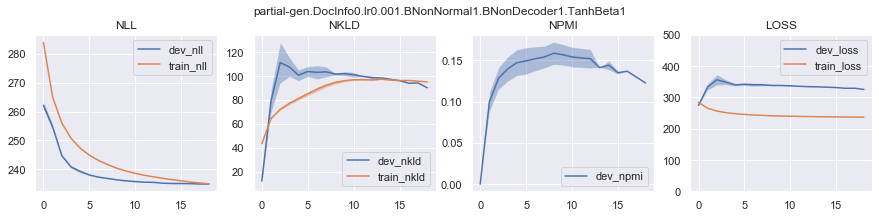

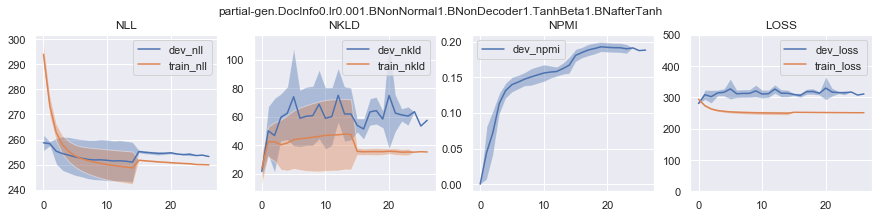

In [252]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1' in model and "Tanh" in model]
pprint(tmp)
compare_TanhonBeta = tmp
_ = plot_models(compare_TanhonBeta)

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.SigmoidBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.SigmoidBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.SigmoidBeta1.BNafterSigmoid']


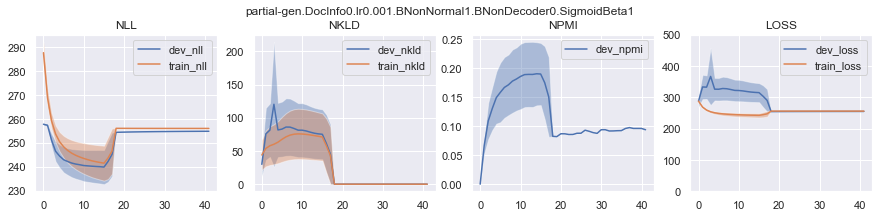

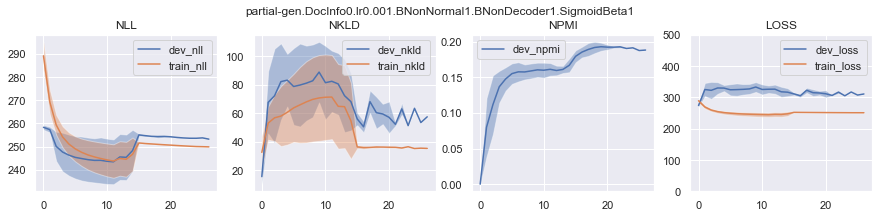

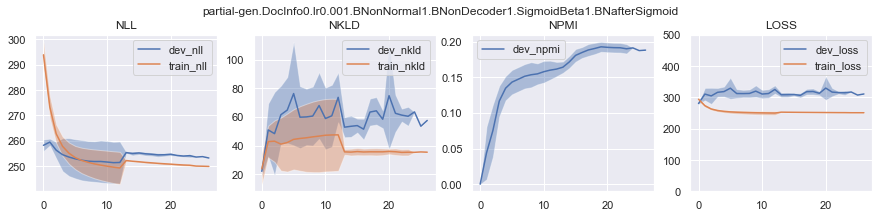

In [253]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1' in model and "Sigmoid" in model]
pprint(tmp)
compare_SigmoidonBeta = tmp
_ = plot_models(compare_SigmoidonBeta)

['partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1.BNafterStochastic',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta0']


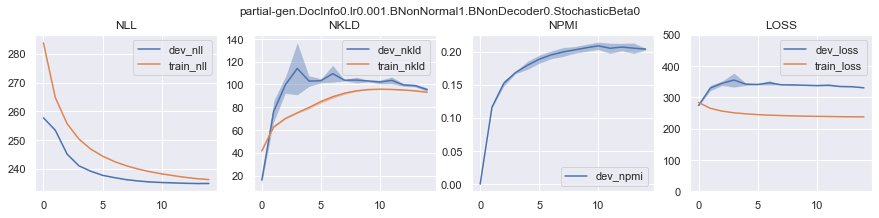

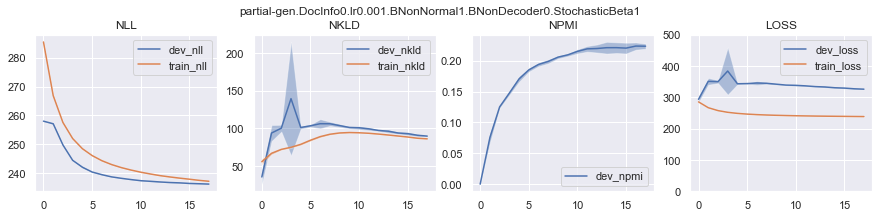

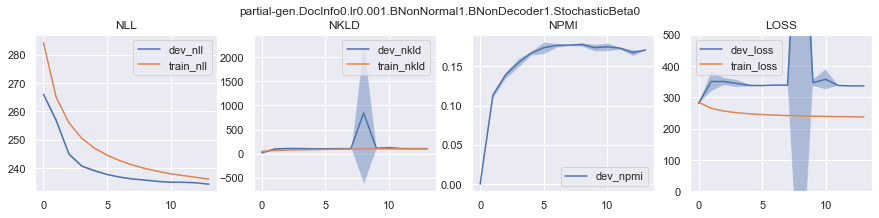

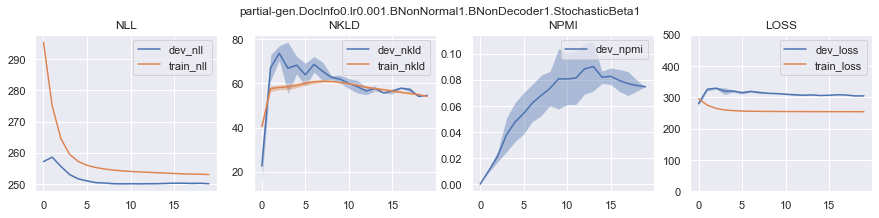

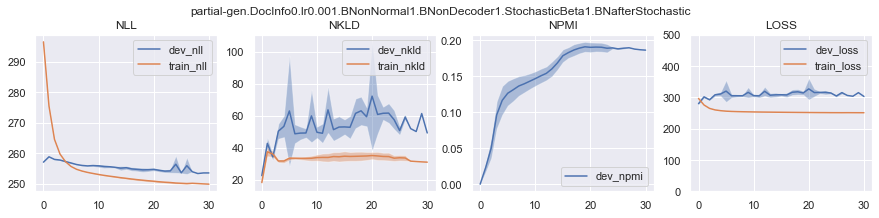

In [256]:
tmp = [model for model in models if 'DocInfo0.lr0.001.BNonNormal1' in model and "Stochastic" in model]
pprint(tmp)
compare_StochasticonBeta = [tmp[2], tmp[3], tmp[4], tmp[0], tmp[1]]
_ = plot_models(compare_StochasticonBeta)

In [257]:
models

['partial-gen.DocInfo1.lr0.01.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.0001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta1.BNafterStochastic',
 'partial-gen.DocInfo1.lr0.001.BNonNormal1.BNonDecoder1.StochasticBeta0',
 'partial-gen.DocInfo1.lr0.00021.BNonNormal0.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr1e-05.BNonNormal0.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.01.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo1.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta1',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder1.TanhBeta1',
 'partial-gen.DocInfo0.lr0.001.

In [297]:
compare_stochastic_beta = [models[-2], models[1], models[-3]]

compare_lr_1 = [models[-2], models[2], models[8], models[9]]
compare_lr_2 = [models[10], models[0]]

compare_BNonNormal = [models[7], models[-2]]

compare_BNonDecoder_1 = [models[8], models[-5]]
compare_BNonDecoder_2 = [models[-9], models[5]]

compare_docinfo_1 = [models[8], models[10]]
compare_docinfo_2 = [models[0], models[9]]
compare_docinfo_3 = [models[14], models[5]]

In [300]:
compare_lr_1

['partial-gen.DocInfo0.lr1e-05.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.0001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.001.BNonNormal1.BNonDecoder0.StochasticBeta0',
 'partial-gen.DocInfo0.lr0.01.BNonNormal1.BNonDecoder0.StochasticBeta0']

# Note: for all the experiments, linear KL-annealing is used 
We confirm that Srivastava et. al's finding that the ProdLDA is better than NVLDA. We believe this is 

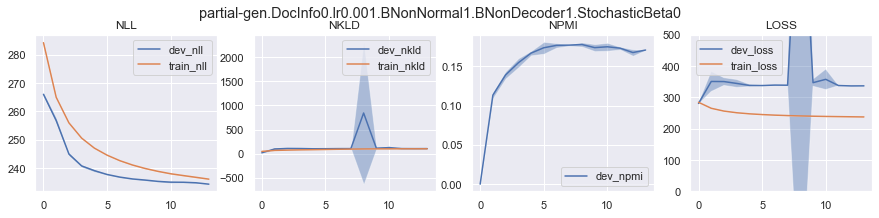

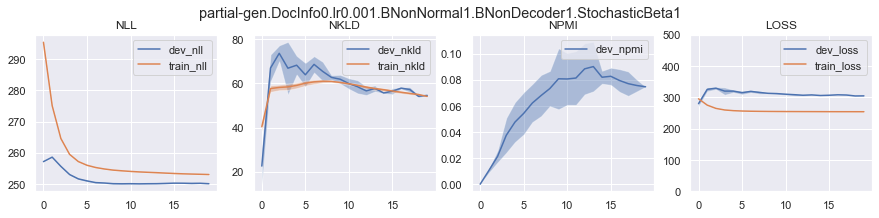

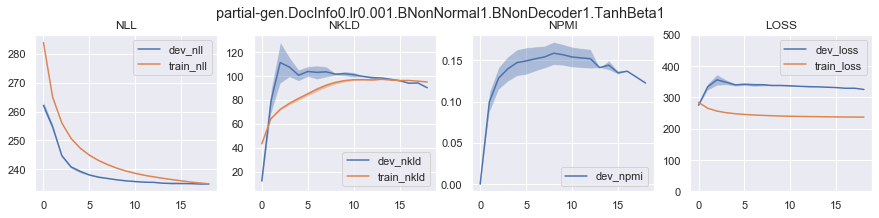

In [211]:
_ = plot_models(compare_stochastic_beta)

We found learning rate between 0.001 and 0.0001 are best suitable for training mini-doc model(without doc information) on nyt dataset. To low will cause model to stuck at a suboptimal, but too high will make model overshoot and quickly collapse word distributions and have redundant topics. 

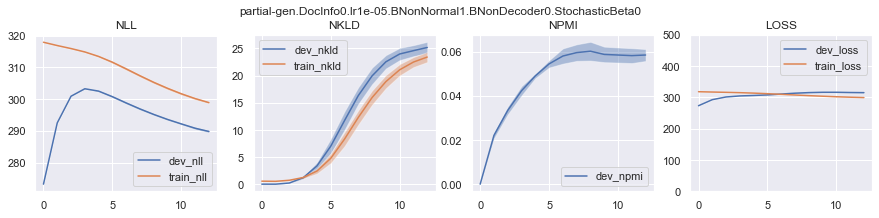

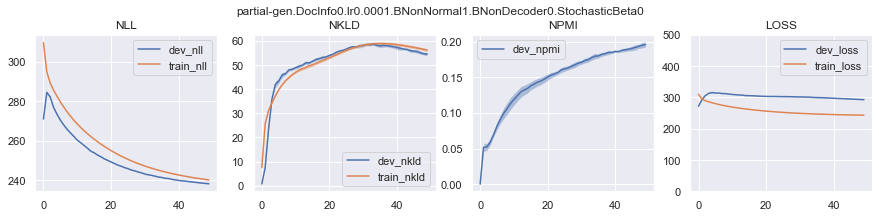

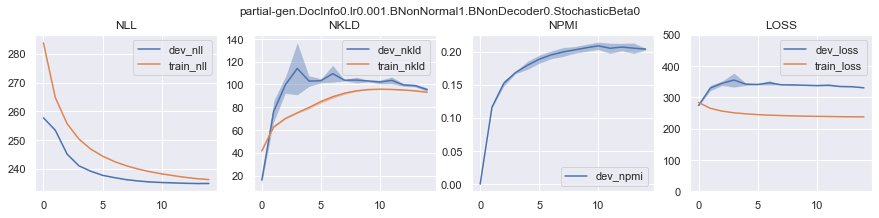

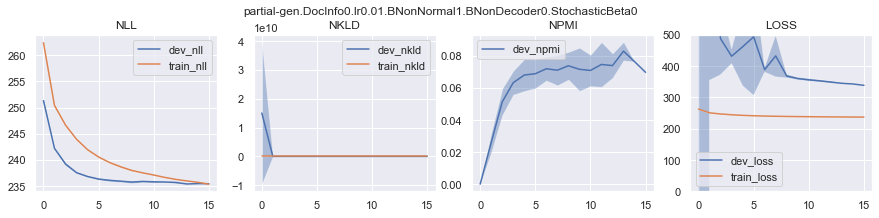

In [301]:
_ = plot_models(compare_lr_1)

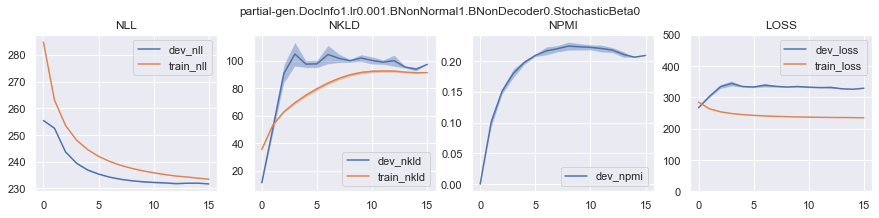

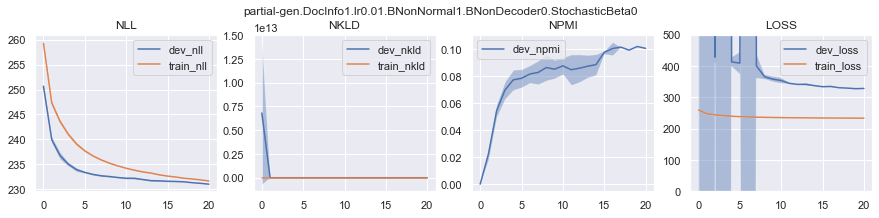

In [269]:
_ = plot_models(compare_lr_2)

Without BNonNormal, higher learning rate (approx. > 1e-5) will lead to overshooting. With BNonNormal, the model has lower reconstruction loss and bettern performance on the reference(dev) corpus

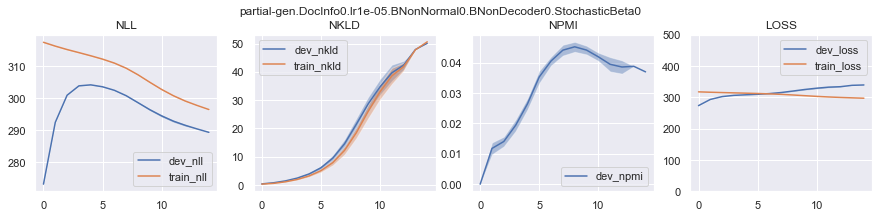

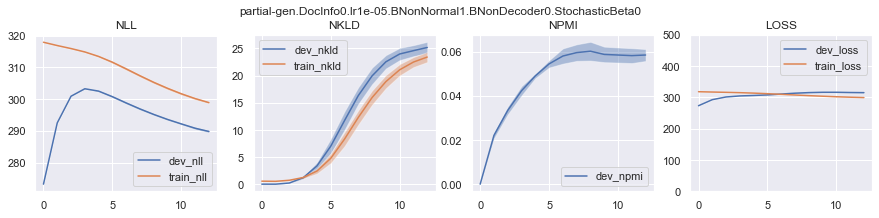

In [270]:
_ = plot_models(compare_BNonNormal)

In AVITM, Srivastava et al. uses feature-wise batch normalization, we found it is not necessary. In fact, feature-wise batch normalization seems harmful to model's performance. 

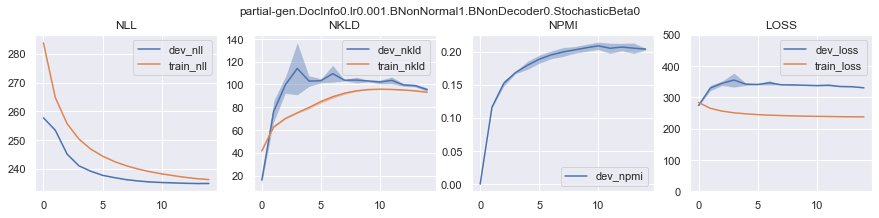

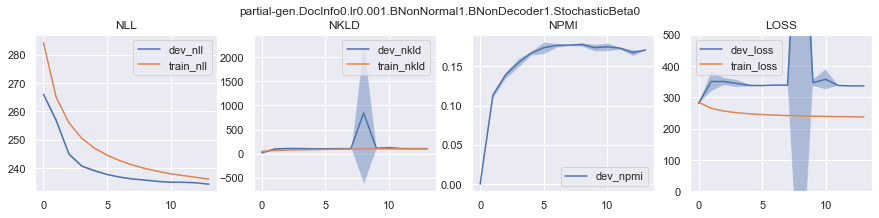

In [292]:
_ = plot_models(compare_BNonDecoder_1) # lr = 0.001, BNonNormal1

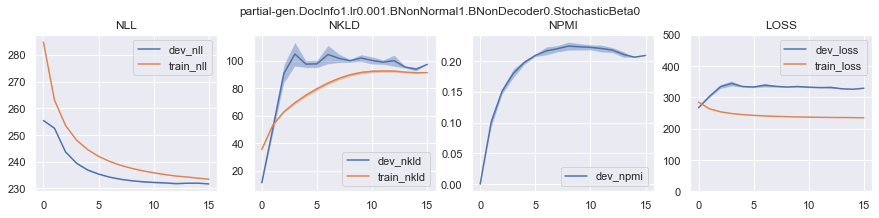

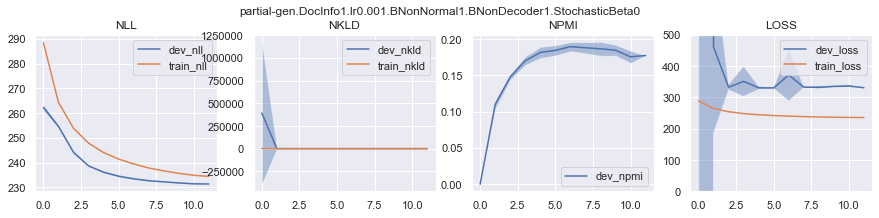

In [296]:
_ = plot_models(compare_BNonDecoder_2) # lr = 0.001, BNonNormal1, DocInfo

Succhin et al shows that "npmi" is a metrics to determine whether a topic modeling have reach its best performance. With document-level information, the model peaks at its best performance more quickly and offer more stable performances across different (seeded) runs.

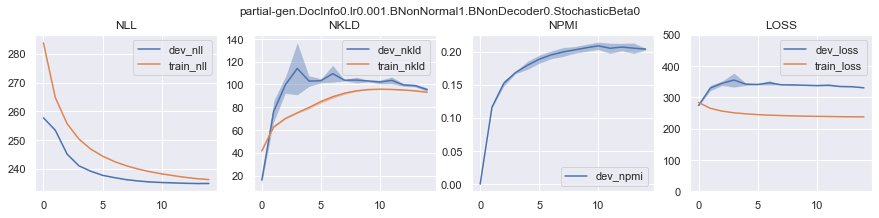

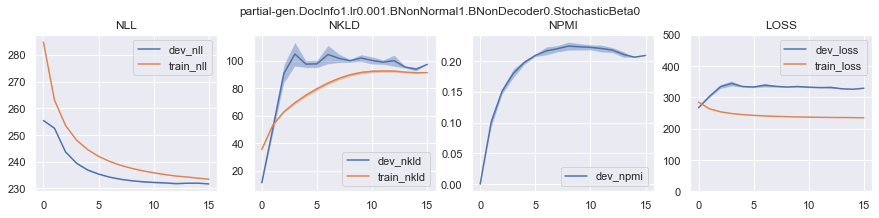

In [277]:
_ = plot_models(compare_docinfo_1) # lr = 0.001, BNonNormal

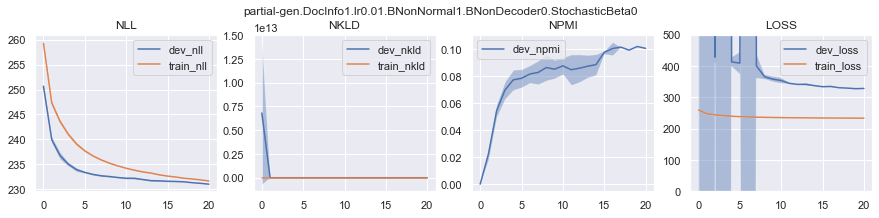

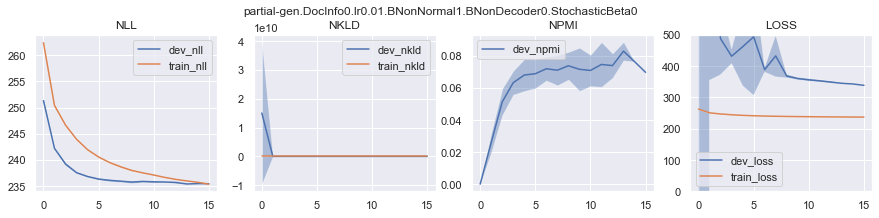

In [280]:
_ = plot_models(compare_docinfo_2) # lr = 0.01, BNonNormal

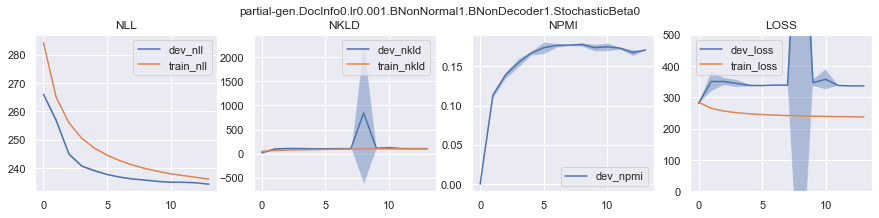

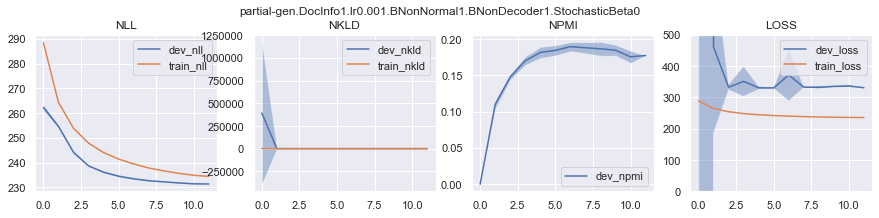

In [285]:
_ = plot_models(compare_docinfo_3) # lr = 0.001, BNonNormal, BNonDecoder